# Fase 3 - Entrenamiento del modelo - BEN GRAHAM 

## Obteniendo la data

In [111]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [112]:
#Paths y classes
path = "Dataset_Recortado"
classes = ['Normal', 'Covid_positive', 'Viral_Pneumonia']
transformation_types = ['B-Channel','ColorMap_JET', 'BEN_GRAHAM']
num_classes = len(classes)
batch_size = 12

In [113]:
num_classes

3

In [114]:
#ImageDataGenerators para cada tipo de transformación
datagen_kwargs = dict(rescale=1./255, validation_split=0.2)
dataflow_kwargs = dict(target_size=(299, 299), class_mode='categorical', batch_size=batch_size, shuffle=True,classes=classes)

#Conjuntos de datos basados en train y test
train_datagen = ImageDataGenerator(**datagen_kwargs)
train_gen = train_datagen.flow_from_directory(directory=path, subset='training', color_mode="rgb", **dataflow_kwargs)
test_gen = train_datagen.flow_from_directory(directory=path, subset='validation', color_mode="rgb", **dataflow_kwargs)

#Conjuntos basados en imágenes transformadas BEN-GRAHAM
train_gen_ben_graham = train_datagen.flow_from_directory(directory=os.path.join(path, 'BEN_GRAHAM'), subset='training', **dataflow_kwargs,color_mode='rgb')
test_gen_ben_graham = train_datagen.flow_from_directory(directory=os.path.join(path, 'BEN_GRAHAM'), subset='validation', **dataflow_kwargs,color_mode='rgb')

Found 12123 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.
Found 6862 images belonging to 3 classes.
Found 1715 images belonging to 3 classes.


In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

#Función para obtener el total de muestras
def get_total_samples(generators):
    return sum(gen.n for gen in generators)


total_train_samples = get_total_samples([train_gen_ben_graham])
total_test_samples = get_total_samples([test_gen_ben_graham])
print(f'Total de muestras en el conjunto de entrenamiento: {total_train_samples}')
print(f'Total de muestras en el conjunto de prueba: {total_test_samples}')


Total de muestras en el conjunto de entrenamiento: 6862
Total de muestras en el conjunto de prueba: 1715


In [118]:
#Visualizar imágenes de prueba
def plot_images(images, labels, title, cmap=None):
    plt.figure(figsize=(12, 12))
    for i in range(min(9, images.shape[0])):
        plt.subplot(3, 3, i + 1)
        if images.shape[-1] == 1:  # Grayscale images
            plt.imshow(images[i, :, :, 0], cmap='gray')
        else:  # RGB images
            plt.imshow(images[i, :, :, :])
        plt.title(f'Label: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

## Entrenamiento del modelo bajo la arquitectura propuesta

In [119]:


#Arquitectura del model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='Same', input_shape=(299, 299, 3)))  # Adjusted for RGB images
model.add(BatchNormalization())
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################

model.add(Flatten())

#Output
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

#Compile the model
opt = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10

In [120]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 299, 299, 32)      896       
                                                                 
 batch_normalization_15 (Ba  (None, 299, 299, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 299, 299, 64)      18496     
                                                                 
 batch_normalization_16 (Ba  (None, 299, 299, 64)      256       
 tchNormalization)                                               
                                                                 
 average_pooling2d_6 (Avera  (None, 149, 149, 64)      0         
 gePooling2D)                                                    
                                                      

In [121]:
history = model.fit(train_gen_ben_graham, validation_data=test_gen_ben_graham, epochs=epochs, verbose=0)

## Mostrando el Accuracy y el Loss del modelo

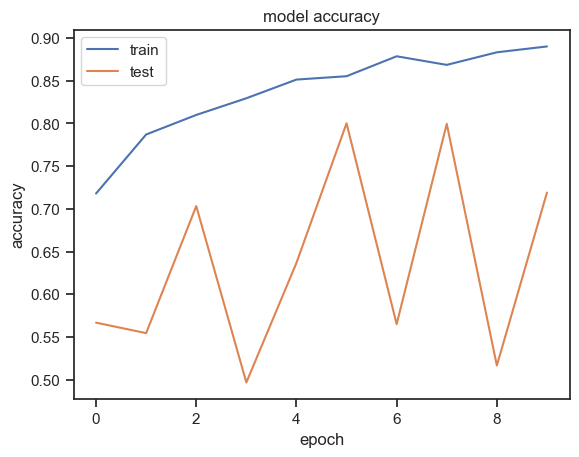

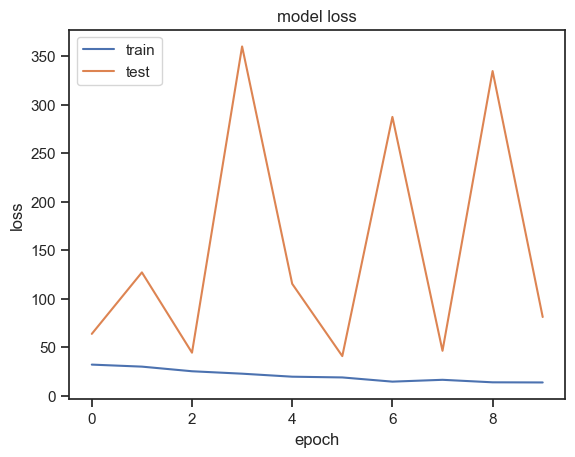

In [122]:
#plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

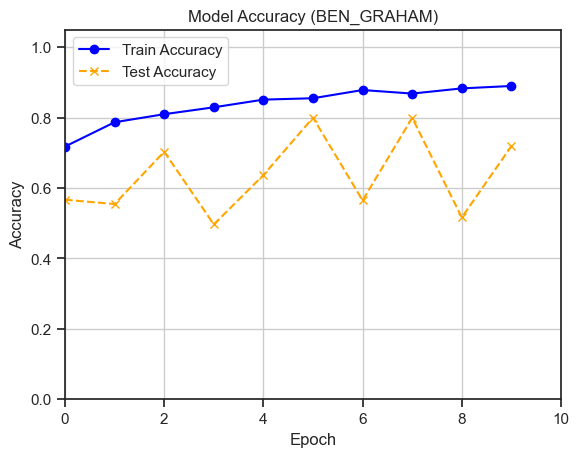

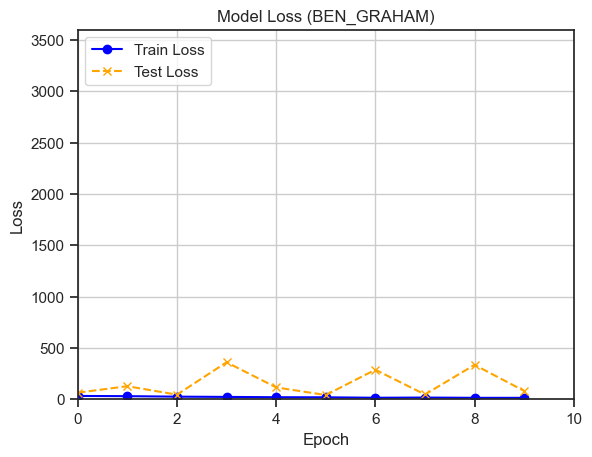

In [123]:
import matplotlib.pyplot as plt

# Configuración del estilo de línea y color para una mejor distinción
plt.plot(history.history['accuracy'], linestyle='-', color='blue', marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='--', color='orange', marker='x', label='Test Accuracy')
plt.title('Model Accuracy (BEN_GRAHAM)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True) 
plt.axis([0, 10, 0, 1.05]) 
plt.show()

plt.plot(history.history['loss'], linestyle='-', color='blue', marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='--', color='orange', marker='x', label='Test Loss')
plt.title('Model Loss (BEN_GRAHAM)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True) 
plt.axis([0, 10, 0, 3600]) 
plt.show()


## Matriz de Confusión

In [124]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    im = ax.imshow(data, **kwargs)

    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    if isinstance(valfmt, str):
        valfmt = tck.StrMethodFormatter(valfmt)

    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [125]:
from sklearn.metrics import confusion_matrix
import numpy as np

true_labels = test_gen_ben_graham.classes

#Predecimos las etiquetas con el modelo
predictions = model.predict(test_gen_ben_graham)
predicted_labels = np.argmax(predictions, axis=1)  # Convertimos las predicciones a etiquetas

#matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(conf_matrix)


143/143 [==============================] - 41s 281ms/step
[[435 203  85]
 [425 213  85]
 [156  82  31]]


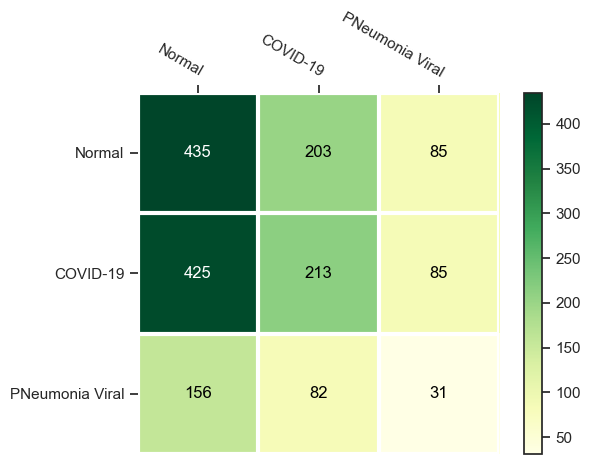

In [126]:
fig, ax = plt.subplots()
axis_labels = ['Normal', 'COVID-19', 'PNeumonia Viral']
im, cbar = heatmap(conf_matrix, axis_labels, axis_labels, ax=ax,
                   cmap="YlGn", cbarlabel="")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
plt.show()